## Introduction

This Notebook will convert addresses into their equivalent latitude and longitude values. It will also use the Foursquare API to explore neighborhoods in Toronto, use the **explore** function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. It will use the *k*-means clustering algorithm to complete this task. Finally, it will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Create Data Frame of Toronto Neighborhoods from Wikipedia Page </a>

2. <a href="#item2">Obtain Latitude and Longitude of Neighborhoods </a> 

   
</font>
</div>

### Download Dependencies 

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#Install website scraping package and parcer package, import BeautifulSoup

#!conda install -c conda-forge beautifulsoup4 --yes #Uncomment line if beautifulsoup4 has not been installed
#!conda install -c conda-forge lxml --yes #Uncomment line if lxml has not been installed
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


### 1. Create Data Frame of Toronto Neighborhoods from Wikipedia Page

Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:
![](https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/7JXaz3NNEeiMwApe4i-fLg_40e690ae0e927abda2d4bde7d94ed133_Screen-Shot-2018-06-18-at-7.17.57-PM.png?expiry=1545868800000&hmac=u23NZ3SR85OnKCQRnfOqtsMbnGrHBrgQGuCS4Pakc9s)

#### Scrape data from Wikipedia

In [7]:
html = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html,'lxml')
#print(soup.prettify())
table = soup.find('tbody') #create an object containing the table information from Wikipedia
#print(table.prettify())

#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
toronto_df = pd.DataFrame(columns=['PostalCode','Borough','Neighborhood']) #Create an empty data frame with the desired column names

Rindex = 0 #Set the starting row index
Cindex = 0 #Set the starting column index
cells = table.find_all('td')
i = 0
for cell in cells: #loop through all occurences of <td> within <tbody>. Note: <td> contains each cell within the table
        Rindex = int(i/3)
        Cindex = i % 3
        if Cindex == 0:
            toronto_df.loc[Rindex] = '' #Create a blank row to fill in with data from Wikipedia
        toronto_df.iloc[Rindex,Cindex] = cell.text #assign the text of the current instance of <td> to the corresponding cell
        i += 1



#### Clean Data

In [8]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
toronto_df.replace('\n', '', regex=True, inplace=True) # remove the \n from strings in the Neighborhood column
toronto_df.drop(toronto_df[toronto_df.Borough == 'Not assigned'].index, inplace=True) #drop rows where borough is not assigned

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for r in range(0,len(toronto_df['Neighborhood'])): #Cycle through all the rows in the data frame
    if toronto_df.iloc[r,2]=='Not assigned': #check if the neighborhood is unassigned
        toronto_df.iloc[r,2] = toronto_df.iloc[r,1] #replace the neighborhood with the borough
        
#More than one neighborhood can exist in one postal code area. 
#For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. 
#These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
groups = pd.DataFrame(toronto_df.groupby(['PostalCode'])['Neighborhood'].apply(', '.join))
for pc in range(0,len(toronto_df['PostalCode'])): #Loop through the rows of the data frame
    PC = toronto_df.iloc[pc,0]  #Determine current postal code in for loop
    PCindex = groups.index.get_loc(PC) #Find the index for the row in groups that matches the current postal code
    toronto_df.iloc[pc,2] = groups.iloc[PCindex,0] #replace neighborhood in toronto_df with the neighborhoods from groups

toronto_df.drop_duplicates(inplace=True) #Drop duplicate rows so there is only 1 row per postal code
toronto_df.reset_index(drop=True, inplace=True) #reset the index


In [9]:
toronto_df.shape #In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

(103, 3)

### 2. Obtain Latitude and Longitude of Neighborhoods

Use the Geocoder package or the csv file to create the following dataframe:
![](https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/HZ3jNHNOEeiMwApe4i-fLg_f44f0f10ccfaf42fcbdba9813364e173_Screen-Shot-2018-06-18-at-7.18.16-PM.png?expiry=1545868800000&hmac=JbgRgo-KXbGsROeU07QAOwJWpLCImBGiMluM3PgizGM)

Double click to see my attempt at using geocoder to find the latitude and longitude
<!--
** This cell has been converted to markdown, because the geocoder was taking too long. The coordinates obtained from the .csv file and processed in the next cell. ** 
 

#!conda install -c conda-forge geocoder --yes #Uncomment line if beautifulsoup4 has not been installed
import geocoder # import geocoder

for code in range(0,len(toronto_df['PostalCode'])):
    postal_code = toronto_df.iloc[code,0]
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
      lat_lng_coords = g.latlng

    latitude[code] = lat_lng_coords[0]
    longitude[code] = lat_lng_coords[1]
-->

In [10]:
# Read in the data from the .csv file
filename = 'Geospatial_Coordinates.csv'
lat_lng_coords = pd.read_csv(filename)
lat_lng_coords.head()
lat_lng_coords.set_index('Postal Code', inplace=True)

In [11]:
#enter the geospacial data in to the toronto_df data frame
toronto_df['Latitude'] = ''
toronto_df['Longitude'] = ''
 
for l in range(0,len(toronto_df['PostalCode'])): #Loop through the rows of the data frame
    code = toronto_df.iloc[l,0]  #Determine current postal code in for loop
    #ind = lat_lng_coords.index.get_loc(code) #Find the index for the row in groups that matches the current postal code 
    coords = lat_lng_coords.loc[code] #enter the latitude in to the toronto_df data frame
    toronto_df.iloc[l,3] = coords[0]
    toronto_df.iloc[l,4] = coords[1] #enter the longitude in to the toronto_df data frame
    
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7533,-79.3297
1,M4A,North York,Victoria Village,43.7259,-79.3156
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.6543,-79.3606
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.7185,-79.4648
4,M7A,Queen's Park,Queen's Park,43.6623,-79.3895


### 3. Explore Venues in Neighborhoods

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

1. to add enough Markdown cells to explain what you decided to do and to report any observations you make.
2. to generate maps to visualize your neighborhoods and how they cluster together.

In [12]:
# Obtain the latitude and longitude of Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
toronto_lat = location.latitude
toronto_lng = location.longitude

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


#### Foursquare

In [13]:
#Define Foursquare Credintials and Version
CLIENT_ID = '4SZ3RB4ZDJIJJ1PC5QZHP5HT1AKMTPLWCJIDH53UZUMRKWJJ' # your Foursquare ID
CLIENT_SECRET = 'HKRGO3VZQTW0E332ZTVVAPYO2XGT3PR2VLAY2DWTZIEQDPDE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#Codes for primary categories
categories_dict = {0:['Arts_Entertainment', '4d4b7104d754a06370d81259'],
              1:['College_University', '4d4b7105d754a06372d81259'],
              2:['Nightlife_Spot', '4d4b7105d754a06376d81259'],
              3:['Outdoors_Recreation', '4d4b7105d754a06377d81259'],
              4:['Residence', '4e67e38e036454776db1fb3a'],
              5:['Travel_Transport', '4d4b7105d754a06379d81259']}

categories = pd.DataFrame.from_dict(categories_dict, orient='index',columns=['Category','ID'])

In [14]:
#function for returning the count of venues in a category within a radius of a location
def get_venues_in_category(names, latitude, longitude, category, radius=200, limit=100):
    venue_count = pd.DataFrame(columns=['Neighborhood',category[0]])
    for n in range(0,len(names)):
        name = names[n]
        lat = latitude[n]
        lng = longitude[n]
        venue_count.loc[n] = ''
    # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&intent=browse'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            category[1])
        results = requests.get(url).json()['response']['venues']
        
        venue_count.iloc[n,0] = name
        venue_count.iloc[n,1] = len(results)
     
    return venue_count

In [15]:
#Run the function on each row in categories
names = toronto_df['Neighborhood']
latitudes = toronto_df['Latitude']
longitudes = toronto_df['Longitude']
venue_count0 = get_venues_in_category(names, latitudes, longitudes, categories.loc[0]) 
print('venue_count0 ready')
venue_count1 = get_venues_in_category(names, latitudes, longitudes, categories.loc[1])
print('venue_count1 ready')
venue_count2 = get_venues_in_category(names, latitudes, longitudes, categories.loc[2])
print('venue_count2 ready')
venue_count3 = get_venues_in_category(names, latitudes, longitudes, categories.loc[3])
print('venue_count3 ready')
venue_count4 = get_venues_in_category(names, latitudes, longitudes, categories.loc[4])
print('venue_count4 ready')
venue_count5 = get_venues_in_category(names, latitudes, longitudes, categories.loc[5])
print('venue_count5 ready')

venue_count0 ready
venue_count1 ready
venue_count2 ready
venue_count3 ready
venue_count4 ready
venue_count5 ready


In [16]:
#Combine the results from the above function into a dataframe
venue_count = pd.concat([venue_count0, venue_count1.iloc[:,1],
                         venue_count2.iloc[:,1], venue_count3.iloc[:,1],  
                         venue_count4.iloc[:,1], venue_count5.iloc[:,1]], axis=1)

#Find the total number of venues for each neighborhood and sort in descending order
venue_count['Total'] = venue_count.iloc[:,1:].sum(axis=1)
venue_count.sort_values(['Total'], ascending=False, inplace=True)
venue_count_less = venue_count[venue_count.Total > 10] #Eliminate Neighborhoods with less than 10 venues
venue_count_less.reset_index(inplace=True)
venue_count_less.drop('index', axis=1, inplace=True)

neighborhoods = venue_count_less.iloc[:,0]
#Truncate the name of the neighborhood(s) if longer than 20 characters for graphing
for r in range(0,len(neighborhoods)):
    neighborhoods[r] = (neighborhoods[r][:20] + '...') if len(neighborhoods[r]) > 20 else neighborhoods[r]
counts = venue_count_less.iloc[:,1:7]
counts = counts.set_index(neighborhoods)
totals = venue_count_less.iloc[:,7]
totals = pd.DataFrame(totals).set_index(neighborhoods)


/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#### Visualize Results

Text(0,0.5,'Number of Venues')

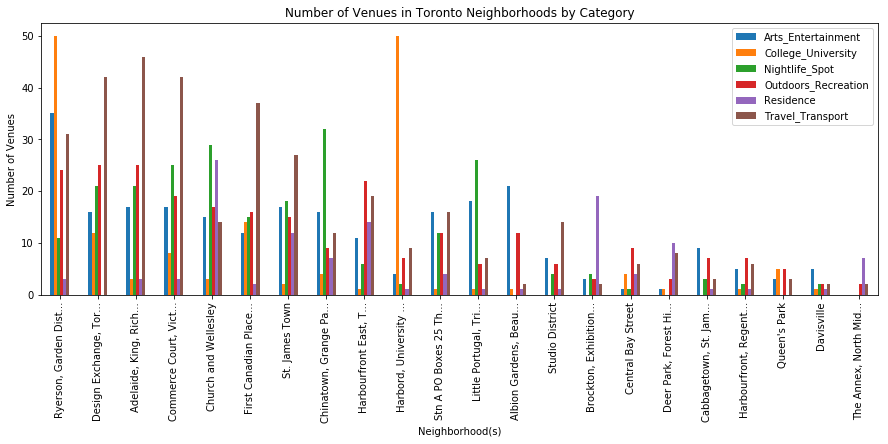

In [17]:
#Plot each neighborhood in a stacked bar chart
fig0 = plt.figure(figsize=(15,5))
ax0 = fig0.add_subplot(1,1,1)
counts.plot(kind='bar', ax=ax0)
ax0.set_title('Number of Venues in Toronto Neighborhoods by Category')
ax0.set_xlabel('Neighborhood(s)')
ax0.set_ylabel('Number of Venues')


Although we set the limit for our Foursquare request to 100, we are only able to retrieve 50 venues. This may bias our data, so we need to look at the values and see which, if any, are affected by this. We can see from the plot above that only 2 data points were clipped at 50, both were College_University. 

Text(0,0.5,'Number of Venues')

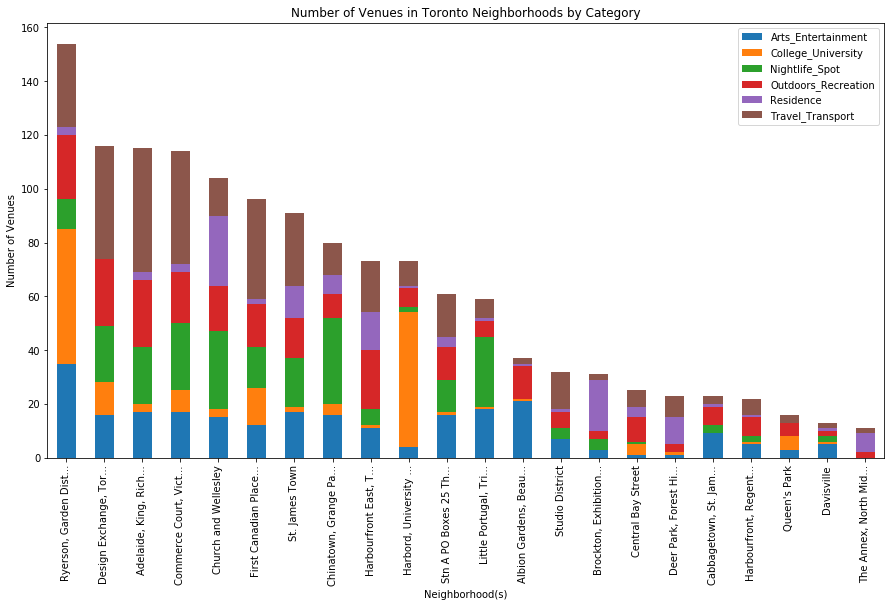

In [18]:
#Create a stacked bar chart to look closer at each neighborhood
fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot(1,1,1)
counts.plot(kind='bar', ax=ax1, stacked=True)
ax1.set_title('Number of Venues in Toronto Neighborhoods by Category')
ax1.set_xlabel('Neighborhood(s)')
ax1.set_ylabel('Number of Venues')

#### Normalize the Data

Normalize the data by the total for each category and the total for each neighborhood. Visualize the results.

In [20]:
#Normalize by total for category
totc = counts.sum(axis=0)
prop_cat = counts.divide(totc)

#Normalize by total for neighborhood
totn = counts.sum(axis=1)
prop_neigh = counts.divide(totn, axis=0)

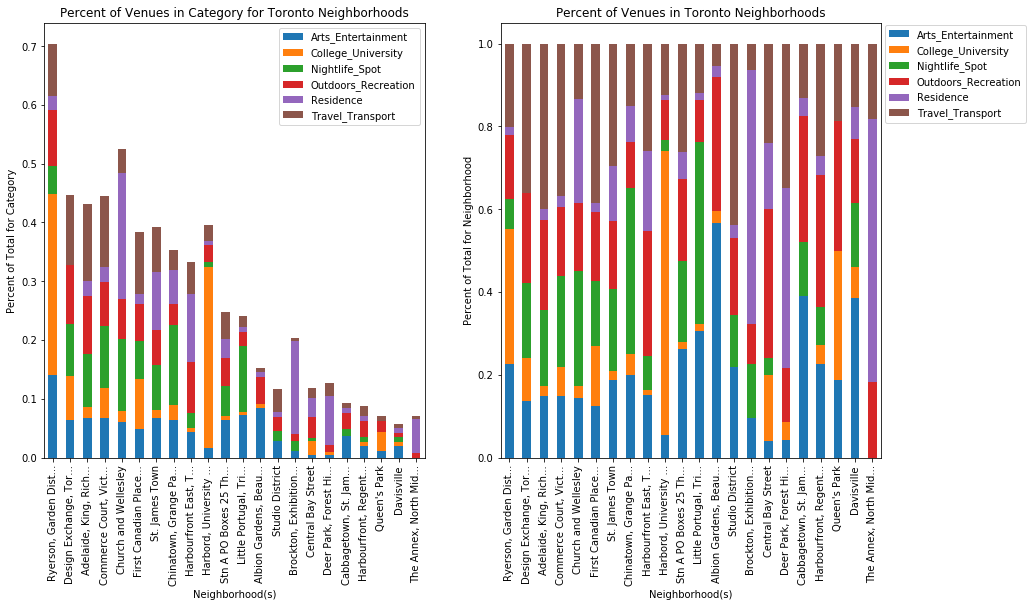

In [21]:
# Create the charts for each
fig2_3 = plt.figure(figsize=(15,8))

ax2 = fig2_3.add_subplot(1, 2, 1)
ax3 = fig2_3.add_subplot(1, 2, 2)

#Subplot 1: Normalized by Category
prop_cat.plot(kind='bar', ax=ax2, stacked=True)
ax2.set_title('Percent of Venues in Category for Toronto Neighborhoods')
ax2.set_xlabel('Neighborhood(s)')
ax2.set_ylabel('Percent of Total for Category')

#Subplot 2: Normalized by Neighborhood
prop_neigh.plot(kind='bar', ax=ax3, stacked=True)
ax3.set_title('Percent of Venues in Toronto Neighborhoods')
ax3.set_xlabel('Neighborhood(s)')
ax3.set_ylabel('Percent of Total for Neighborhood')
ax3.legend(loc=(1.01,.77))

### 4. Cluster Neighborhoods

We will use k=4 clusters for simplicity. Ideally, we would evaluate the results for various values of k. However, this is beyond the scop of this notebook.

We will cluster neighborhoods using the normalized data. We will perform the clustering twice, once with the data normalized by total for category and once with data normalized by neighborhood. We will then look at the resulting clusters to determine which method results in more distinguished clusters. Clustering with the category normalized data takes into account the number of venues in the neighborhood, where as clustering with the neighborhood normalized data treats all the neighborhoods as if they have the same number of venues.

In [22]:
# set number of clusters 
k = 4

# run k-means clustering multiple times, without setting a random_state variable to ensure the global optimum
N = 10 #Number of times to run KMeans
kmeans_cat = KMeans(k, n_init=N).fit(prop_cat)
kmeans_neigh = KMeans(k, n_init=N).fit(prop_neigh)

clusters_cat = prop_cat
clusters_cat['Cluster'] = kmeans_cat.labels_
clusters_neigh = prop_neigh
clusters_neigh['Cluster'] = kmeans_neigh.labels_

#### Visualize Clusters

We will create two figures for each clustering. The first will look at the clusters. The second will look at the neighborhoods in each cluster.

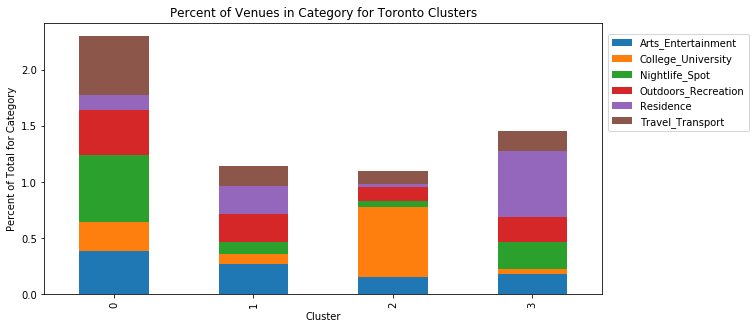

In [23]:
#Group and sum clusters for data normalized by category total
group_cluster_cat = clusters_cat.groupby('Cluster').sum()

#Plot clusters
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(1,1,1)
group_cluster_cat.plot(kind='bar', ax=ax4, stacked=True)
ax4.set_title('Percent of Venues in Category for Toronto Clusters')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Percent of Total for Category')
ax4.legend(loc=(1.01,.6))

The following figure is a plot with 4 subplots, one for each cluster. We will set the y-axis limits and bar width to have uniformity across the sub plots. A chart that is grouped and stacked would be better, but requires more work as matplotlib is unable to do this as is. 

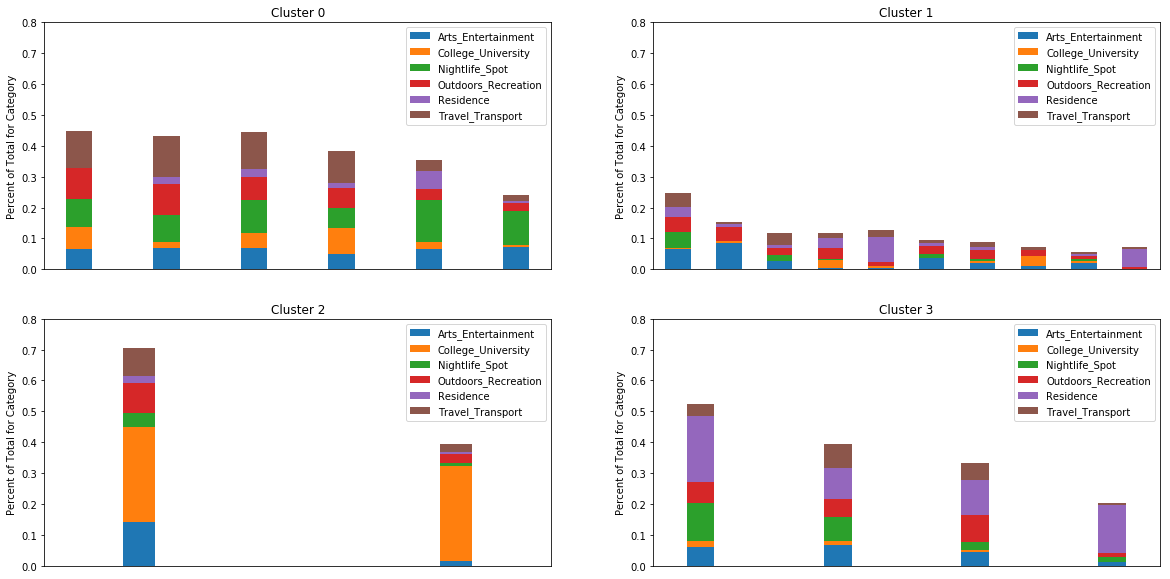

In [24]:
#Plot the breakdown of neighborhoods in each cluster
cc0 = clusters_cat[clusters_cat.Cluster == 0].drop(['Cluster'], axis=1) #Pull only the proportions for category 0
cc1 = clusters_cat[clusters_cat.Cluster == 1].drop(['Cluster'], axis=1) #Pull only the proportions for category 1
cc2 = clusters_cat[clusters_cat.Cluster == 2].drop(['Cluster'], axis=1) #Pull only the proportions for category 2
cc3 = clusters_cat[clusters_cat.Cluster == 3].drop(['Cluster'], axis=1) #Pull only the proportions for category 3

fig5_8 = plt.figure(figsize=(20,10))

ylim = 0.8 #Define the y-axis top limit

ax5 = fig5_8.add_subplot(2,2,1) 
cc0.plot(kind='bar', ax=ax5, stacked=True, width=len(cc0)/20) #width of bars depends on length of data len/20 will result in uniform bar widths across each sub plot 
ax5.set_title('Cluster 0')
ax5.set_ylabel('Percent of Total for Category')
ax5.set_ylim(top=ylim) #set the top limit for the y-axis
ax5.xaxis.set_visible(False) #Remove x-axis for readability

ax6 = fig5_8.add_subplot(2,2,2)
cc1.plot(kind='bar', ax=ax6, stacked=True, width=len(cc1)/20)
ax6.set_title('Cluster 1')
ax6.set_ylabel('Percent of Total for Category')
ax6.set_ylim(top=ylim)
ax6.xaxis.set_visible(False)

ax7 = fig5_8.add_subplot(2,2,3)
cc2.plot(kind='bar', ax=ax7, stacked=True, width=len(cc2)/20)
ax7.set_title('Cluster 2')
ax7.set_ylabel('Percent of Total for Category')
ax7.set_ylim(top=ylim)
ax7.xaxis.set_visible(False)

ax8 = fig5_8.add_subplot(2,2,4)
cc3.plot(kind='bar', ax=ax8, stacked=True, width=len(cc3)/20)
ax8.set_title('Cluster 3')
ax8.set_ylabel('Percent of Total for Category')
ax8.set_ylim(top=ylim)
ax8.xaxis.set_visible(False)

We can see that the number of venues in the neighborhood has a significant impact on the cluster. For example, the neighborhoods in cluster 1 all have a small number of venues. Since we are interested in the make up of the venues more than the number of the venues, this clustering is not ideal.

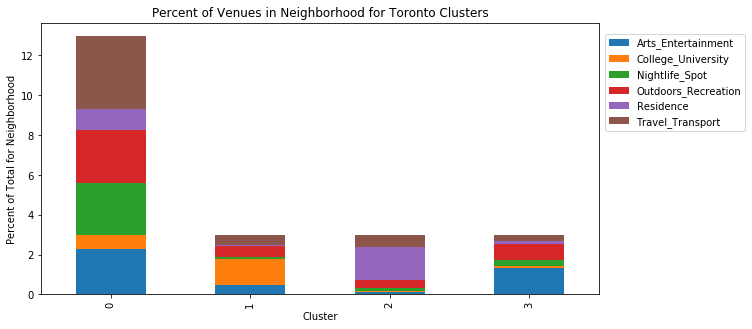

In [25]:
#Group and sum clusters for data normalized by neighborhood total
group_cluster_neigh = clusters_neigh.groupby('Cluster').sum()

#Plot clusters
fig9 = plt.figure(figsize=(10,5))
ax9 = fig9.add_subplot(1,1,1)
group_cluster_neigh.plot(kind='bar', ax=ax9, stacked=True)
ax9.set_title('Percent of Venues in Neighborhood for Toronto Clusters')
ax9.set_xlabel('Cluster')
ax9.set_ylabel('Percent of Total for Neighborhood')
ax9.legend(loc=(1.01,.6))

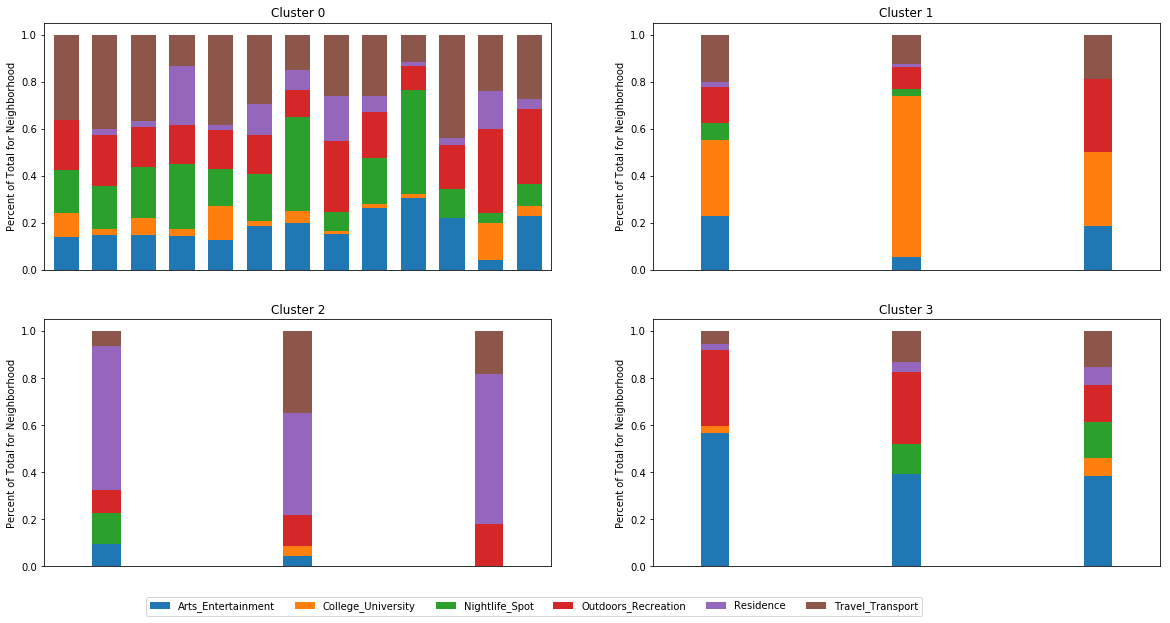

In [26]:
#Plot the breakdown of neighborhoods in each cluster
cn0 = clusters_neigh[clusters_neigh.Cluster == 0].drop(['Cluster'], axis=1) #Pull only the proportions for category 0
cn1 = clusters_neigh[clusters_neigh.Cluster == 1].drop(['Cluster'], axis=1) #Pull only the proportions for category 1
cn2 = clusters_neigh[clusters_neigh.Cluster == 2].drop(['Cluster'], axis=1) #Pull only the proportions for category 2
cn3 = clusters_neigh[clusters_neigh.Cluster == 3].drop(['Cluster'], axis=1) #Pull only the proportions for category 3

fig10_13 = plt.figure(figsize=(20,10))

ax10 = fig10_13.add_subplot(2,2,1) 
cn0.plot(kind='bar', ax=ax10, stacked=True, legend=False, width=len(cn0)/20) #width of bars depends on length of data len/20 will result in uniform bar widths across each sub plot 
ax10.set_title('Cluster 0')
ax10.set_ylabel('Percent of Total for Neighborhood')
ax10.xaxis.set_visible(False) #Remove x-axis for readability

ax11 = fig10_13.add_subplot(2,2,2)
cn1.plot(kind='bar', ax=ax11, stacked=True, legend=False, width=len(cn1)/20)
ax11.set_title('Cluster 1')
ax11.set_ylabel('Percent of Total for Neighborhood')
ax11.xaxis.set_visible(False)

ax12 = fig10_13.add_subplot(2,2,3)
cn2.plot(kind='bar', ax=ax12, stacked=True, legend=False, width=len(cn2)/20)
ax12.set_title('Cluster 2')
ax12.set_ylabel('Percent of Total for Neighborhood')
ax12.xaxis.set_visible(False)

ax13 = fig10_13.add_subplot(2,2,4)
cn3.plot(kind='bar', ax=ax13, stacked=True, width=len(cn3)/20)
ax13.set_title('Cluster 3')
ax13.set_ylabel('Percent of Total for Neighborhood')
ax13.xaxis.set_visible(False)
ax13.legend(ncol=6, loc=(-1,-.2))

Based on the charts, we will use the clusters generated from the data normalized by the neighborhood count. We can make the following observations from fig10_13:

Cluster 0: These neighborhoods contain a healthy mix of venue categories within their radius. These neighborhoods may be in central locations. We can also see they contain approximately 40% to 10% transportation venues, further indicating they are central neighborhoods.

Cluster 1: These neighborhoods contain a significant proportion of College_University. We can expect there to be higher education institutes in these neighborhoods.

Cluster 2: These neighborhoods are likely residential areas given the distinguishable portion of residence venues not seen in the other clusters.

Cluster 3: These neighborhoods have a significant proportion of Arts_Entertainment and Outdoors_Recreation. These may be tourist areas.

The map overlain with the cluster markers can help us evaluate these assumptions.

##### Plot Clusters on Map

In [56]:
#Create a dataframe with the neighborhood, latitude, longitude, and cluster label

toronto_results = clusters_neigh.drop('Neighborhood', axis=1)
toronto_results.reset_index(inplace=True)
toronto_results.drop('Neighborhood',axis=1,inplace=True)
toronto_results['Neighborhood'] = venue_count['Neighborhood']
toronto_results = toronto_results.join(toronto_df.set_index('Neighborhood'), on='Neighborhood')



In [70]:
# create map
map_clusters = folium.Map(location=[toronto_lat, toronto_lng], zoom_start=10)

#set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_results['Latitude'], toronto_results['Longitude'], toronto_results['Neighborhood'], toronto_results['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters